<a href="https://colab.research.google.com/github/grace3999/PPs/blob/master/5_FIFI_image_CNN_transferlearn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification of 'Find it, Fix it' Photos

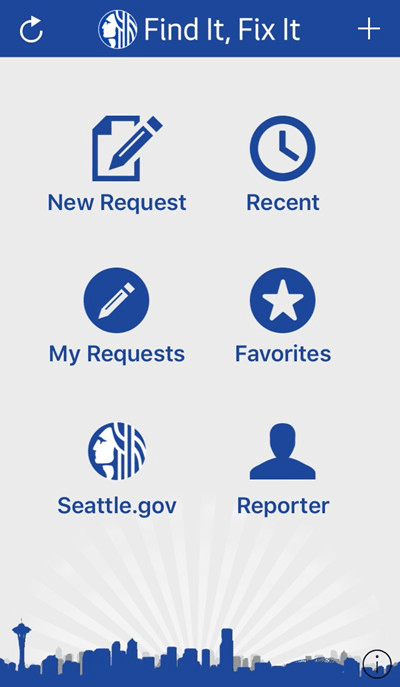

## Impetus for this Project 

Every day, residents use the City of Seattle's 'Find It, Fix It' (FIFI) app to report problems they want to the City to address, _e.g._ abandoned vehicles, grafitti, broken streetlights, and etc. Each report includes text, date and location information, and may also include images. As a result, the City receives several hundred thousand images every year via the FIFI app. The City would like to incorporate these citizen reports into city planning efforts, but they don't have the resources to comb through images.  

Our goal is to assist the City by providing meaningful classifications based on the image and text data, so the City can effectively allocate municipal resources. Ideally, the City would like to identify both emergent and systemic problems, and get the classification when each image is submitted via the FIFI app.  

### Project Goals
1. Assist the City with sorting the reports categorized as "Other" by analyzing the text and image data.  
2. Assist the City in filtering out priority reports for quick action and/or distribution to appropriate municipal department.  

### Technical Goals
1. Use transfer learning to design a CNN for image classification.  
2. Train the CNN on labeled FIFI Category images to classify "Other" images as one of the defined FIFI Categories (or potentially none if none of the classes apply).  
3. Adjust the model parameters to fine-tune the model architecture and improve validation accuracy.  

## About the Data

The image data used in this project came from a public records request to the City of Seattle for its records of reports made in the 'Find it, Fix it' (FIFI) app. The original dataset consisted of 248,815 individual reports and 67 feature columns received over a 5.5 year period: 2014 - 2019. However, not all reports included an image.  

Originally, the FIFI images were grouped into 12 categories, and these categories were set by the City of Seattle and/or the FIFI app developer, _e.g._ `'Needles/Dumping'` or `'Streetlight'`. 

It's important to note that the individual citizen reporters selected the category label when they submitted their reports in the FIFI app. It turns out, the `Other` category was most popular. Obviously the `Other` label provides limited information. It just tells us that the citizen reporters didn't believe that any of the other 11 categories adequately described their reports.   

The original data columns included both descriptive features of the report and general census data about the location:  
#### Original Substantive Features
```
['Service_Request_Number' 'Created_Date' 'Location'
'Location_Details' 'Description' 'License_Number' 'State'
'Vehicle_Make' 'Vehicle_Color' 'Time_parked' 'Photo'
'FIFI_category' 'Location_Details.1' 'Property_damage?'
'Current_Issue' 'Type_of_animal' 'On_private_property?'
'Graffiti_location' 'Location_and_Description'
'Obscene/Racial/Hateful?' 'Street/Intersection' 'Where?'
'Type_of_item?' 'Veg_location' 'Vegetation_Safety_Issue'
'Parking_Violation_Concerning' 'License_Plate_Number'
'Location_details' '7_digit_number_on_pole'
'Issue' 'date' 'year' 'month' 'day' 'day_of_week' 'hour'
'zip' 'neighborhood' 'SittingInformal' 'Lying' 
'DisruptiveActivity_Aggressive' 'DisruptiveActivity_Intoxicated'
'LivingActivities' 'Soliciting' 'overdose']
```  
 #### Inferred Census Data Features
```
['pop' 'pop_dens' 'housing_units' 'med_home' 'land_area'
'occupied_units' 'occupied_ratio' 'med_income'
'med_age' 'male_%' 'white_%' 'fam_%' 'nokid_%' 'mortgage_%'
'fulltime_%' 'unemploy' 'drive_%' 'publictrans_%' 'other_%'
'wrk_travel' 'city council' 'county council'] 
```  

[Link to image data](https://drive.google.com/open?id=199RtfIK0zihXu1L9-WSzGiN6sTa1HeHb)  
 
 #### Original Category Labels
 The FIFI app established 12 category labels:  
```
['Abandoned Vehicle', 'Community Walk', 'Grafitti',
'Needles/Dumping', 'Parking', 'Pothole', 'Streetlight',
'Other', 'Clogged_Drain', 'Dead Animal',
'Vegetation', 'Sign/Signal']
```  

#### Category Labels Used in Training
The original dataset was unbalanced, with more images in some categories. So, some classes were combined and other classes were dropped to balance the training data. The final classes included:  
```
['Abandoned Vehicle', 'Clogged_Drain', 'Grafitti',
'Needles/Dumping', 'Parking', 'Pothole','Sign/Signal/Light']
```  


## Insights

The FIFI image classifier model was built upon the pretrained InceptionV3, so lower layer feature extractions correspond to the original 1000 classes which do not necessarily contain our image classes. We have also observed that the FIFI images do not fall neatly into single categories (even to the human eye). Therefore, we believe analyzing the corresponding text associated with each image would greatly increase model accuracy.


## Results
  
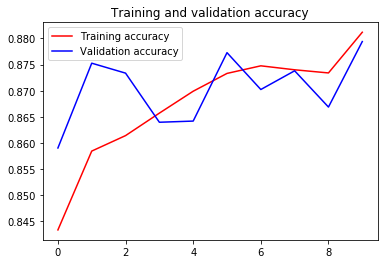

Model overfitting was an issue starting almost immediately. The model performs well on "other" category images that fell neatly into one of the original training categories but peformed poorly on images not related to one of the training categories (e.g. tents and encampments). We chose to use a balanced data set (1100 images per class) but despite additional image augmentaion in TensorFlow, the model may require additional training images for certain categories to be accurately classified.


## Future Work

1. Create a classifier to sort images into level of seriousness/priority, e.g. scale 1-3. This will help the City prioritize reports for response. 
2. Extract additional categories/classes/labels from the FIFI report text to finetune classes. A classifier that provides additional detail will also assist the City in prioritizing municipal resources. 


## Acknowledgemnts

Laurence Maroney and Coursera TensorFlow in Practice; WIDS meetup; InceptionV3 creators; City of Seattle FIFI


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import os
import requests 
from multiprocessing.pool import ThreadPool
import time
import random
from shutil import copyfile

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
#path for FIFI cleaned and preprocessed data frame
path_FIFI = '/content/gdrive/My Drive/WIDS_FIFI_groupproject/generated_datasets/data_final.pkl'

#read in pkl file containing 
data = pd.read_pickle(path_FIFI)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)

print('Original data shape:\n', data.shape, '\n')

#clean data, combine 'sign/signal' and 'streetlight' 
data = data[data['FIFI_category'] != 'Community Walk']
data['FIFI_category'] = data['FIFI_category'].replace({'Needles/Dumping': 'Needles_Dumping', 'Sign/Signal': 'Sign_Signal_Light', 'Streetlight': 'Sign_Signal_Light'})

#we are only interested in FIFI requests that have a photo included with the request
print(data.shape)
data_photo = data[~data['Photo'].isna()]
print(data_photo.shape)

print(data_photo['FIFI_category'].value_counts())

Original data shape:
 (248815, 67) 

(248661, 67)
(183278, 67)
Needles_Dumping      40265
Other                34428
Grafitti             31749
Abnd_Vehicle         26656
Parking              25140
Pothole              13154
Sign_Signal_Light    11398
Clogged_Drain        427  
Vegetation           44   
Dead Animal          17   
Name: FIFI_category, dtype: int64


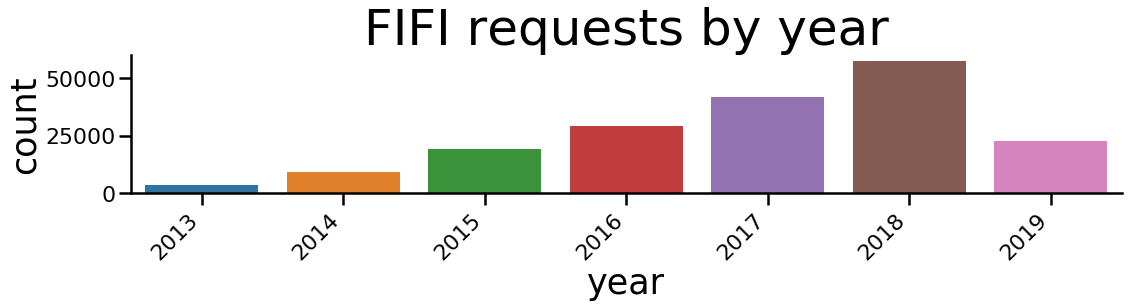

In [0]:
#how do counts change across years?
g = sns.catplot(x='year', data=data_photo, kind='count', height=4, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('FIFI requests by year', y=1.25)
plt.subplots_adjust(hspace = 1.5)

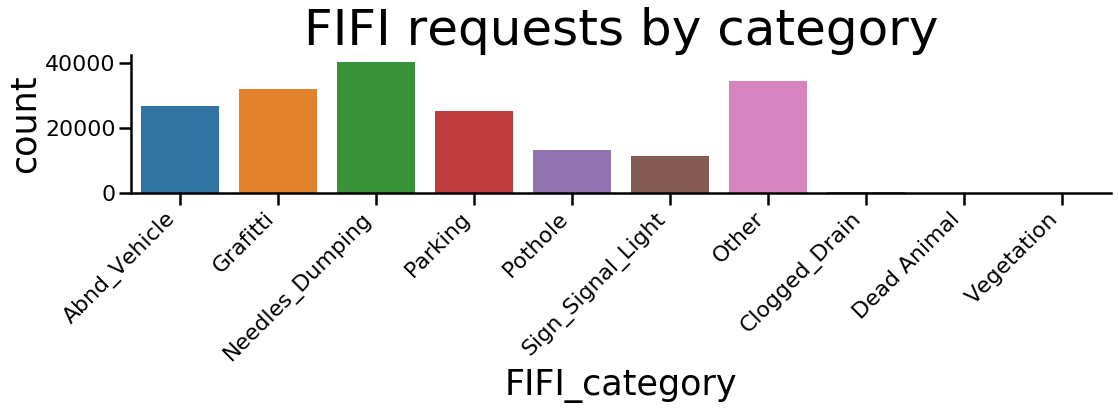

In [0]:
#how do counts change across FIFI_category?
g = sns.catplot(x='FIFI_category', data=data_photo, kind='count', height=4, aspect=4)
g.set_xticklabels(rotation=45, ha='right')
plt.title('FIFI requests by category', y=1.25)
plt.subplots_adjust(hspace = 1.5)

In [0]:
#create a directory for each category
try:
    os.mkdir('/tmp/FIFI_photos/')
except:
    pass

save_path = '/tmp/FIFI_photos/'

train_cats = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Sign_Signal_Light']

for cat in train_cats:
    if os.path.exists(os.path.join(save_path, cat)) == True:
      print(cat, " already exists")
    else:
      os.mkdir(os.path.join(save_path, cat))
      print(cat, " directory created")

Abnd_Vehicle  directory created
Grafitti  directory created
Needles_Dumping  directory created
Parking  directory created
Pothole  directory created
Sign_Signal_Light  directory created


In [0]:
#create function to get photo from url and save
def fetch_and_save(image_url_tupple):
    image_name, image_url = image_url_tupple
    #create file name for photo
    image_name = os.path.join(save_path_cat, image_name)  
    #get photo from url and save
    r = requests.get(image_url, allow_redirects=True)
    open(image_name, 'wb').write(r.content)

#use '/tmp/' for faster performance
save_path = '/tmp/FIFI_photos/'

#do each category individually, random select 1000 for each category (colab freezes at around 8000 downloads)
for cat in train_cats:

  size = 1100
  theads = 5
  save_path_cat = os.path.join(save_path, cat)
  random.seed(39)

  print(cat)
  cat_data = data_photo[data_photo['FIFI_category'] == cat].reset_index() 
  #get list of randomly selected indexes of specificed size
  random_index = random.sample(list(cat_data.index.values), size)
  cat_data_random = cat_data[cat_data.index.isin(random_index)].reset_index()

  i = 0
  while i < cat_data_random.shape[0]:
    if i%100 == 0:
      print(i)
    #run on multiple threads for faster performance, save each photo with 'service_request_number' for later indexing
    urls = list(zip([cat+'_'+str(x)+'.jpeg' for x in cat_data_random['Service_Request_Number'].iloc[i:i+theads]], cat_data_random['Photo'][i:i+theads]))
    ThreadPool(theads).imap_unordered(fetch_and_save, urls)
    i += theads

Abnd_Vehicle
0
100
200
300
400
500
600
700
800
900
1000
Grafitti
0
100
200
300
400
500
600
700
800
900
1000
Needles_Dumping
0
100
200
300
400
500
600
700
800
900
1000
Parking
0
100
200
300
400
500
600
700
800
900
1000
Pothole
0
100
200
300
400
500
600
700
800
900
1000
Sign_Signal_Light
0
100
200
300
400
500
600
700
800
900
1000


In [0]:
#create directories for training and testing 
project_dir = '/tmp/'

try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/training'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/testing'))
except OSError:
  pass


In [0]:
#create directories for train/test for each FIFI category 
photo_categories = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Sign_Signal_Light']

train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  try:
    os.mkdir(os.path.join(train_dir, cat))
  except OSError:
   print('cannot make directory for train: ', cat)
  try:
    os.mkdir(os.path.join(test_dir, cat))
  except OSError:
   print('cannot make directory for test: ', cat)

In [0]:
#function to split data into training and testing based on a specified split size
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)

In [0]:
photos_dir = '/tmp/FIFI_photos/'
train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  print(cat)
  source_dir = os.path.join(photos_dir, cat)
  train_dir_cat = os.path.join(train_dir, cat)
  test_dir_cat = os.path.join(test_dir, cat)

  split_size = .7
  start_time = time.time()
  split_data(source_dir, train_dir_cat, test_dir_cat, split_size)
  print("--- %s seconds ---" % (time.time() - start_time))


Abnd_Vehicle
--- 1.1861279010772705 seconds ---
Grafitti
--- 0.8213768005371094 seconds ---
Needles_Dumping
--- 1.5885694026947021 seconds ---
Parking
--- 1.0664255619049072 seconds ---
Pothole
--- 1.6779658794403076 seconds ---
Sign_Signal_Light
--- 1.6617605686187744 seconds ---


In [0]:
#download weights and import model to use for transfer learning
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

--2019-12-01 20:13:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  51.8MB/s    in 1.6s    

2019-12-01 20:13:42 (51.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                              

In [0]:
#at LM suggestion use 'mixex7' as last layer from InceptionV3
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)                  
x = layers.Dense  (6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


last layer output shape:  (None, 7, 7, 768)


In [0]:
#train CNN using images from each category besides 'other'

TRAINING_DIR = '/tmp/cnn_cat_other/training/'
VALIDATION_DIR = '/tmp/cnn_cat_other/testing/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150),
                                                    batch_size=30)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(VALIDATION_DIR,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150),
                                                         batch_size=30)

Found 0 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>.998):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 1)

#callbacks=[callbacks]

Epoch 1/10
100/100 [==============================] - 152s 2s/step - loss: 0.3868 - acc: 0.8434 - val_loss: 0.3453 - val_acc: 0.8590
Epoch 2/10
100/100 [==============================] - 139s 1s/step - loss: 0.3380 - acc: 0.8585 - val_loss: 0.3282 - val_acc: 0.8753
Epoch 3/10
100/100 [==============================] - 137s 1s/step - loss: 0.3274 - acc: 0.8614 - val_loss: 0.3447 - val_acc: 0.8734
Epoch 4/10
100/100 [==============================] - 137s 1s/step - loss: 0.3173 - acc: 0.8657 - val_loss: 0.3743 - val_acc: 0.8640
Epoch 5/10
100/100 [==============================] - 137s 1s/step - loss: 0.3025 - acc: 0.8699 - val_loss: 0.3925 - val_acc: 0.8642
Epoch 6/10
100/100 [==============================] - 137s 1s/step - loss: 0.3031 - acc: 0.8733 - val_loss: 0.3728 - val_acc: 0.8773
Epoch 7/10
100/100 [==============================] - 137s 1s/step - loss: 0.2953 - acc: 0.8747 - val_loss: 0.4096 - val_acc: 0.8702
Epoch 8/10
100/100 [==============================] - 136s 1s/step - 

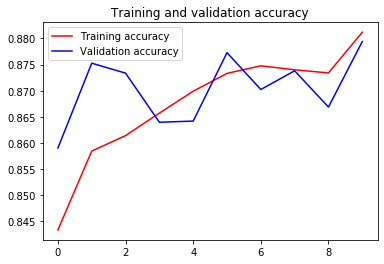

<Figure size 432x288 with 0 Axes>

In [0]:
#viz train and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:
#save model for future use
model.save('/content/gdrive/My Drive/WIDS_FIFI_groupproject/6_class.h5')

In [0]:
#Load trained model
model = tf.keras.models.load_model('/content/gdrive/My Drive/WIDS_FIFI_groupproject/6_class.h5')

# Show the model architecture
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864  

In [0]:
#create function to get photo from url and save
def fetch_and_save(image_url_tupple):
    image_name, image_url = image_url_tupple
    #create file name for photo
    image_name = os.path.join(save_path_other, image_name)  
    #get photo from url and save
    r = requests.get(image_url, allow_redirects=True)
    open(image_name, 'wb').write(r.content)

#use fetch_and_save function to randomlly download images from the "other" category
save_path = '/tmp/FIFI_photos/'
cat = 'Other'
size = 50
theads = 5
try:
  os.mkdir(os.path.join(save_path, cat))
except:
  print('directory already created')
save_path_other = os.path.join(save_path, cat)
random.seed(39)

cat_data = data_photo[data_photo['FIFI_category'] == cat].reset_index() 
random_index = random.sample(list(cat_data.index.values), size)
cat_data_random = cat_data[cat_data.index.isin(random_index)].reset_index()

i = 0
while i < cat_data_random.shape[0]:
  if i%10 == 0:
    print(i)
  #run on multiple threads for faster performance, save each photo with 'service_request_number' for later indexing
  urls = list(zip([cat+'_'+str(x)+'.jpeg' for x in cat_data_random['Service_Request_Number'].iloc[i:i+theads]], cat_data_random['Photo'][i:i+theads]))
  ThreadPool(theads).imap_unordered(fetch_and_save, urls)
  i += theads

0
10
20
30
40


In [0]:
#get class indices from trained model
class_dic = train_generator.class_indices
print(class_dic)
print('\n')

{'Abnd_Vehicle': 0, 'Grafitti': 1, 'Needles_Dumping': 2, 'Parking': 3, 'Pothole': 4, 'Sign_Signal_Light': 5}




{'Abnd_Vehicle': 0, 'Grafitti': 1, 'Needles_Dumping': 2, 'Parking': 3, 'Pothole': 4, 'Sign_Signal_Light': 5}


Other_18-00239774.jpeg


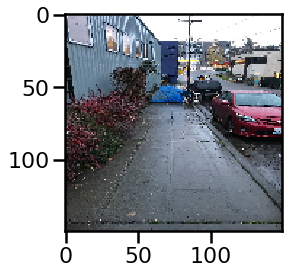

[[1. 0. 0. 0. 0. 0.]]
Abnd_Vehicle


Other_16-00133962.jpeg


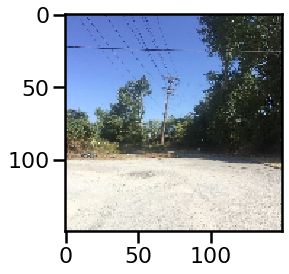

[[1. 0. 0. 0. 0. 0.]]
Abnd_Vehicle


Other_17-00093171.jpeg


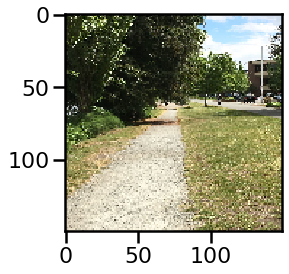

[[0.00000002 0.00000012 0.         0.         0.         0.9999999 ]]
Sign_Signal_Light


Other_17-00154264.jpeg


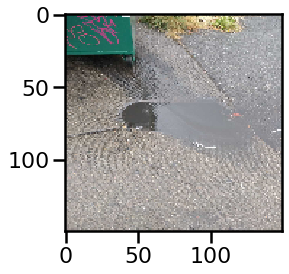

[[0. 1. 0. 0. 0. 0.]]
Grafitti


Other_17-00118412.jpeg


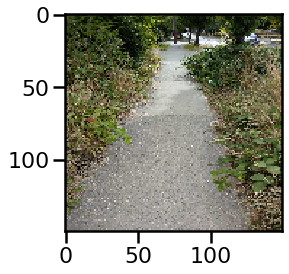

[[0.00000823 0.6826732  0.00000033 0.         0.         0.31731823]]
Grafitti


Other_19-00048842.jpeg


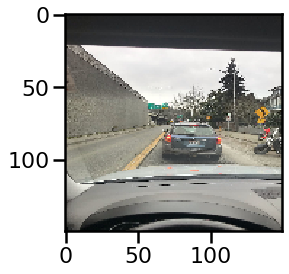

[[0. 1. 0. 0. 0. 0.]]
Grafitti


Other_13-00077132.jpeg


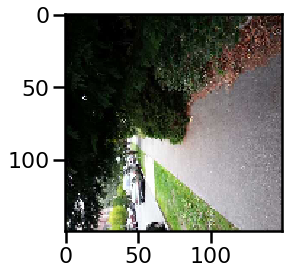

[[0.99533147 0.00000052 0.         0.         0.         0.00466809]]
Abnd_Vehicle


Other_18-00249544.jpeg


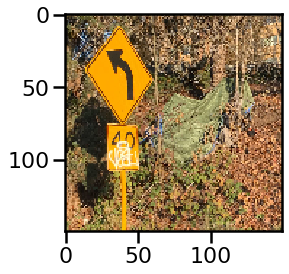

[[0.0022911  0.03304986 0.20055786 0.         0.0000147  0.76408654]]
Sign_Signal_Light


Other_16-00205331.jpeg


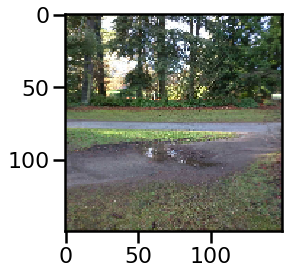

[[0.         0.00000007 0.         0.         0.0000005  0.9999994 ]]
Sign_Signal_Light


Other_18-00113038.jpeg


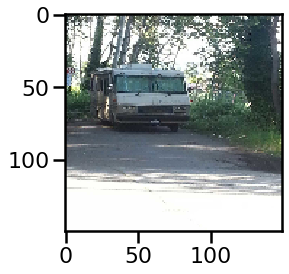

[[1. 0. 0. 0. 0. 0.]]
Abnd_Vehicle


Other_19-00057323.jpeg


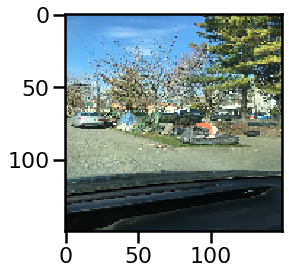

[[0. 1. 0. 0. 0. 0.]]
Grafitti


Other_18-00025173.jpeg


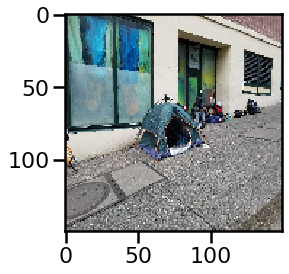

[[0.         0.3350136  0.00000006 0.         0.         0.66498643]]
Sign_Signal_Light


Other_15-00156321.jpeg


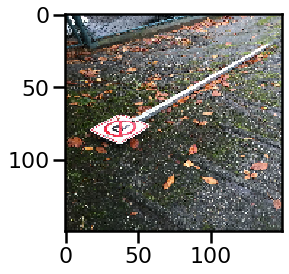

[[0.00003984 0.00228458 0.         0.         0.         0.9976756 ]]
Sign_Signal_Light


Other_19-00018937.jpeg


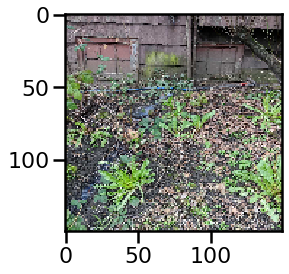

[[0.00000292 0.998159   0.00000575 0.         0.0006303  0.00120198]]
Grafitti


Other_17-00196290.jpeg


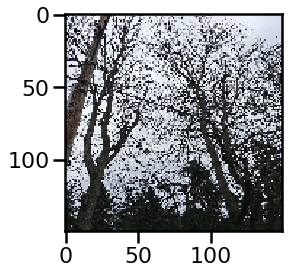

[[0.00000002 0.99485993 0.00026102 0.00001459 0.00000418 0.00486031]]
Grafitti


Other_15-00182744.jpeg


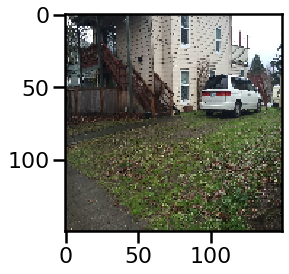

[[0.04340759 0.00000002 0.00000001 0.         0.0003689  0.9562235 ]]
Sign_Signal_Light


Other_19-00090086.jpeg


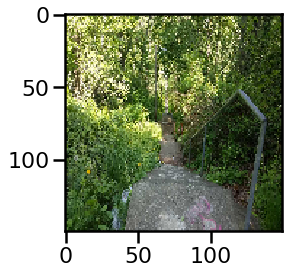

[[0.14194864 0.00118687 0.00672545 0.00000001 0.         0.850139  ]]
Sign_Signal_Light


Other_15-00086918.jpeg


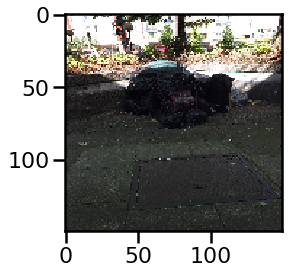

[[0.00003581 0.00000157 0.         0.         0.         0.99996257]]
Sign_Signal_Light


Other_13-00064726.jpeg


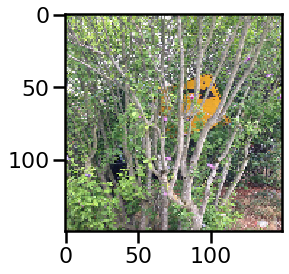

[[0.         1.         0.         0.         0.         0.00000002]]
Grafitti


Other_18-00021955.jpeg


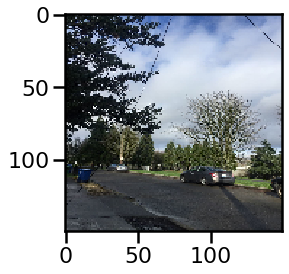

[[0.         0.00000044 0.         0.         0.         0.9999995 ]]
Sign_Signal_Light


Other_16-00082130.jpeg


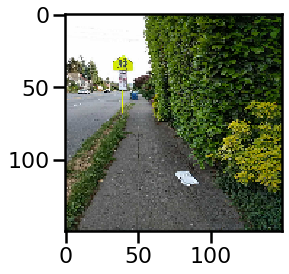

[[0.         0.00000115 0.         0.         0.         0.9999988 ]]
Sign_Signal_Light


Other_13-00090721.jpeg


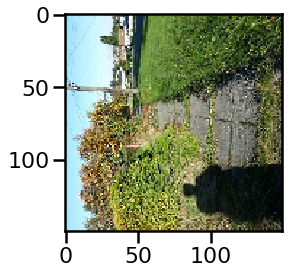

[[0.         0.00001063 0.         0.         0.         0.9999894 ]]
Sign_Signal_Light


Other_16-00191013.jpeg


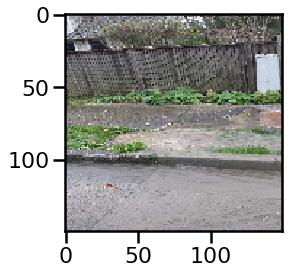

[[0.98570794 0.00085479 0.         0.         0.         0.01343736]]
Abnd_Vehicle


Other_18-00032299.jpeg


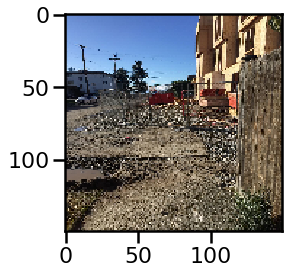

[[0.00000034 0.00000003 0.00000277 0.         0.00000001 0.9999969 ]]
Sign_Signal_Light


Other_18-00259544.jpeg


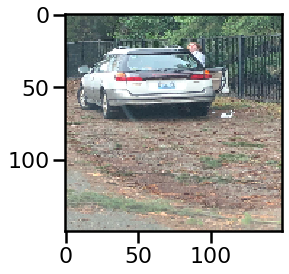

[[0. 1. 0. 0. 0. 0.]]
Grafitti


Other_19-00035083.jpeg


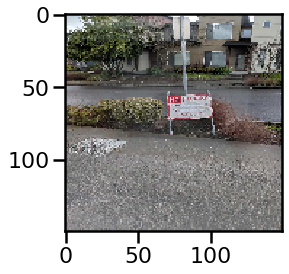

[[0.99876714 0.00102692 0.         0.         0.         0.00020599]]
Abnd_Vehicle


Other_15-00182315.jpeg


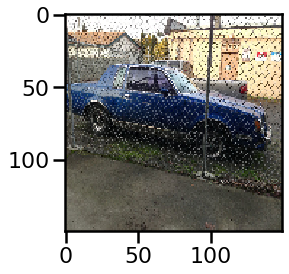

[[0.03277344 0.00000272 0.         0.         0.00000008 0.96722376]]
Sign_Signal_Light


Other_19-00031124.jpeg


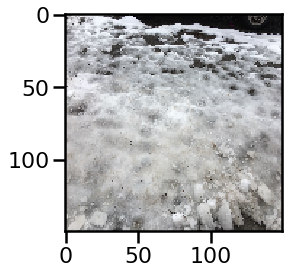

[[0.         0.9999995  0.         0.         0.         0.00000043]]
Grafitti


Other_17-00037872.jpeg


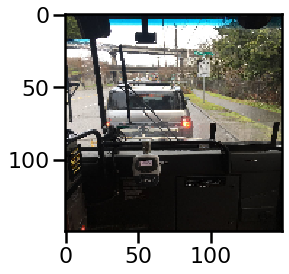

[[0.         0.99898857 0.         0.         0.         0.0010114 ]]
Grafitti


Other_18-00112625.jpeg


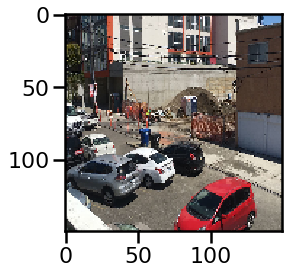

[[0.08882475 0.54981697 0.         0.         0.         0.3613583 ]]
Grafitti


Other_18-00251426.jpeg


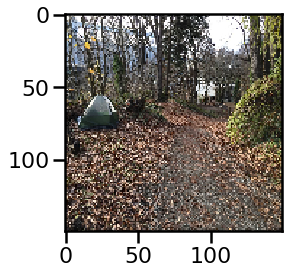

[[0.00009473 0.99980015 0.00000588 0.00000032 0.00001149 0.00008748]]
Grafitti


Other_17-00110057.jpeg


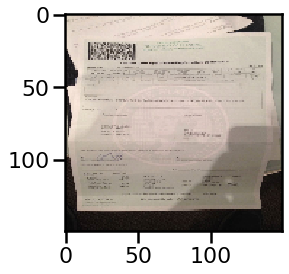

[[0. 1. 0. 0. 0. 0.]]
Grafitti


Other_15-00075707.jpeg


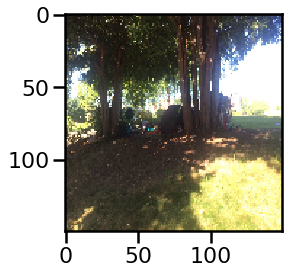

[[0.00093463 0.         0.         0.         0.         0.99906534]]
Sign_Signal_Light


Other_18-00219232.jpeg


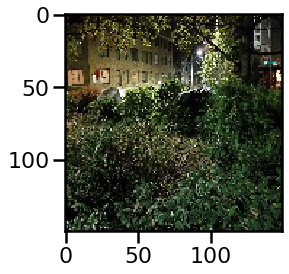

[[0.00698314 0.03560163 0.8013297  0.00004643 0.00003487 0.15600426]]
Needles_Dumping


Other_16-00080570.jpeg


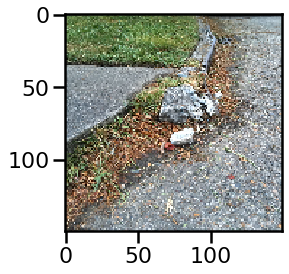

[[0.00082541 0.9991715  0.         0.         0.00000283 0.00000029]]
Grafitti


Other_18-00112762.jpeg


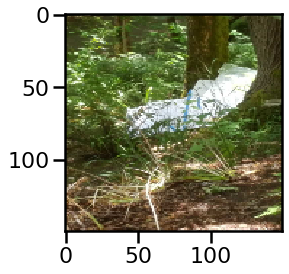

[[0.9999925  0.00000002 0.00000014 0.         0.         0.00000739]]
Abnd_Vehicle


Other_15-00094245.jpeg


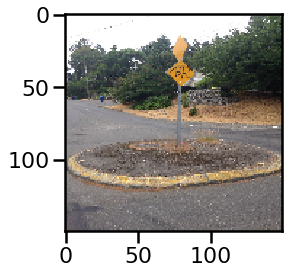

[[0.00022923 0.00001012 0.         0.         0.         0.9997607 ]]
Sign_Signal_Light


Other_17-00024379.jpeg


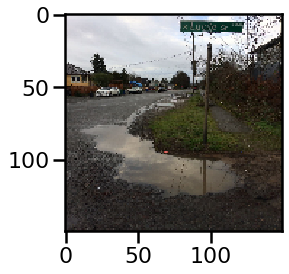

[[0. 0. 0. 0. 0. 1.]]
Sign_Signal_Light


Other_14-00083961.jpeg


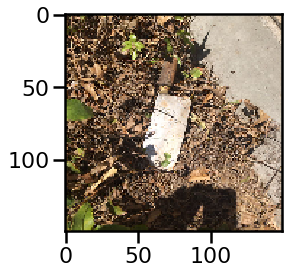

[[0.00000051 0.99999523 0.00000001 0.         0.         0.00000427]]
Grafitti


Other_16-00026251.jpeg


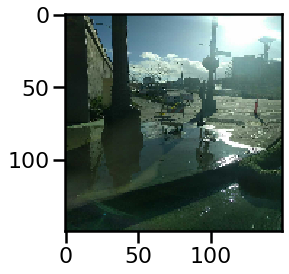

[[0.00629883 0.00000096 0.         0.         0.00006647 0.99363375]]
Sign_Signal_Light


Other_18-00203079.jpeg


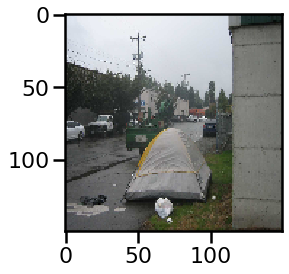

[[0.         0.48655614 0.         0.         0.00000011 0.51344377]]
Sign_Signal_Light


Other_15-00003916.jpeg


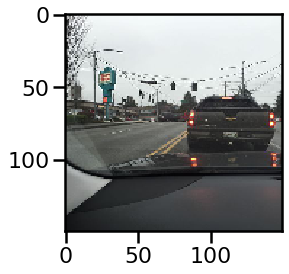

[[0.         0.00316533 0.         0.         0.         0.9968347 ]]
Sign_Signal_Light


Other_17-00158063.jpeg


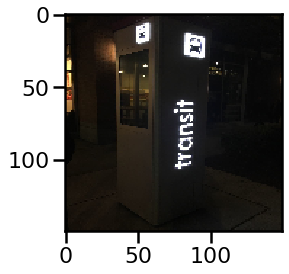

[[0.         0.00428282 0.         0.00000247 0.00009325 0.9956214 ]]
Sign_Signal_Light


Other_17-00201731.jpeg


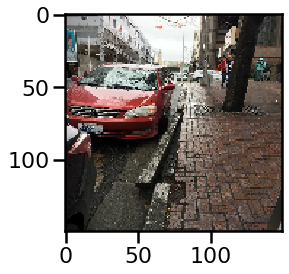

[[0.         0.00329732 0.         0.         0.         0.99670273]]
Sign_Signal_Light


Other_16-00166088.jpeg


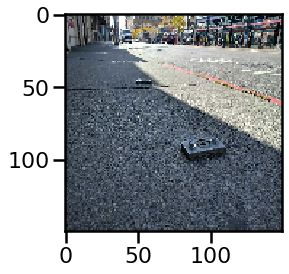

[[0.         0.06894339 0.         0.         0.00435198 0.9267047 ]]
Sign_Signal_Light


Other_14-00088683.jpeg


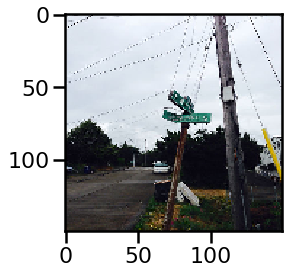

[[0. 0. 0. 0. 0. 1.]]
Sign_Signal_Light


Other_17-00154170.jpeg


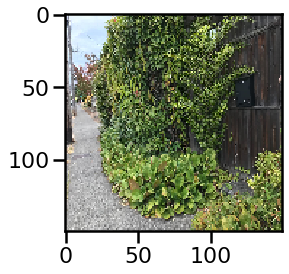

[[0.00000011 0.         0.00001478 0.         0.         0.9999851 ]]
Sign_Signal_Light


Other_16-00149187.jpeg


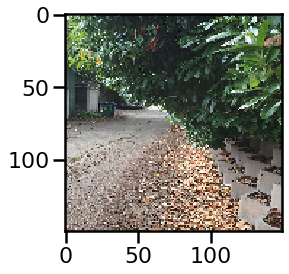

[[0.00001465 0.99195147 0.00036165 0.         0.         0.00767229]]
Grafitti


Other_17-00098138.jpeg


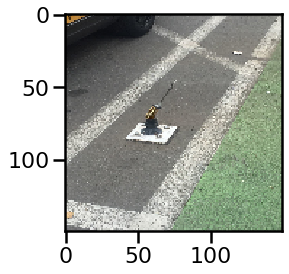

[[0.         0.99906856 0.         0.         0.         0.0009315 ]]
Grafitti


Other_16-00161681.jpeg


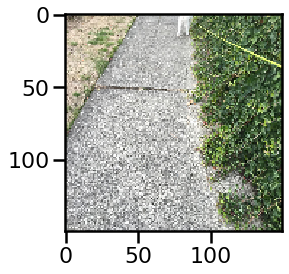

[[0.         0.999754   0.         0.         0.         0.00024599]]
Grafitti




In [0]:
#prepare images, run through model, compare to image
predict = {}
for dir_img in os.listdir(save_path_other):
  print(dir_img)
  img_path = os.path.join(save_path_other, dir_img)
  img = image.load_img(img_path, target_size=(150, 150))
  #show image
  plt.imshow(img)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  pred = model.predict(x)
  print(pred)
  #get index for prediction and use with class dic
  class_index = list(np.round(pred[0],0)).index(1)
  print(list(class_dic.keys())[list(class_dic.values())[class_index]])
  print('\n')